## Aki's Amazing Automated FLood EXtent mapping tool - A3FLEX

In [1]:
from a3flex_code import get_current_flood_events, get_coordinates_for_event, create_polygon_from_bbox
from a3flex_code import connect_to_sentinel_api, get_available_satellite_images, download_satellite_image
from a3flex_code import preprocess_using_snap, extract_satellite_image, crop_satellite_image
from a3flex_code import get_water_body_file_url, crop_image, get_water_threshold_from_water_bodies
from a3flex_code import get_altitude_file_url, extract_altitude_file, calculate_slopes
from a3flex_code import create_binary_mask

In [2]:
import rasterio as rio
from rasterio.warp import Resampling
import matplotlib.pyplot as plt
import urllib.request
import os
import numpy as np

%matplotlib inline

### Manual ROI input
Provide the coordinates for a flood event

In [3]:
lon_min = 4.2
lat_min = 51.50
lon_max = 4.8
lat_max = 52.7
bbox = [lon_min, lon_max, lat_min, lat_max]

In [4]:
roi = create_polygon_from_bbox(bbox)
print('bbox: ', bbox)
print('roi (polygon): ', roi)

bbox:  [4.2, 4.8, 51.5, 52.7]
roi (polygon):  [(4.2, 51.5), (4.8, 51.5), (4.8, 52.7), (4.2, 52.7), (4.2, 51.5)]


### Satellite image download
Downloads the satellite image for the selected region into data folder or skip and provide your own file

In [5]:
sentinel_api = connect_to_sentinel_api()
available_images = get_available_satellite_images(sentinel_api, roi)

Querying products: 100%|██████████| 146/146 [00:00<00:00, 171.89 products/s]


In [6]:
available_images[['ingestiondate', 'instrumentname', 'overlap_with_roi']].head(5)

,ingestiondate,instrumentname,overlap_with_roi
ea2a2324-a32c-4599-bfb5-025e7e47a96c,2019-09-16 01:42:52.650,Synthetic Aperture Radar (C-band),1.0
be779fd6-f29e-417b-b7bc-7b39f2b50bf1,2019-09-08 21:01:54.060,Synthetic Aperture Radar (C-band),1.0
7bd52cd4-b4bc-4537-a4c1-080beaef4078,2019-09-03 21:14:49.144,Synthetic Aperture Radar (C-band),1.0
374aa91d-effb-4edc-97c1-63ed7cb79851,2019-08-27 20:43:01.140,Synthetic Aperture Radar (C-band),1.0
27598adc-a4da-4189-8aee-c68222bfa6bd,2019-08-22 20:44:58.894,Synthetic Aperture Radar (C-band),1.0


In [7]:
download = download_satellite_image(sentinel_api, available_images.iloc[0].name, '../data')

Downloading: 100%|██████████| 994M/994M [03:05<00:00, 5.35MB/s] 
MD5 checksumming: 100%|██████████| 994M/994M [00:01<00:00, 561MB/s] 


### Preprocessing of satellite data
For preprocessing of the satellite data we use the SNAP graph processing tool. Please point to the gpt executable. The graph to be executed is included in the code

In [9]:
# path_to_satellite_raw = '../data/S1A_IW_GRDH_1SDV_20190917T055827_20190917T055852_029057_034C21_19D3.zip'
path_to_satellite_raw = download['path']
path_to_gpt = '/Applications/snap/bin/gpt'
path_to_graph = os.path.abspath('denoiseGraph.xml')
path_to_cropped = os.path.abspath('../output/NL_test2_cropped.dim')
path_to_output = os.path.abspath('../output/NL_test2_preprocessed.tif')

In [10]:
print('extracting satellite image')
path_to_satellite_image = os.path.abspath(extract_satellite_image(path_to_satellite_raw))
print('cropping satellite image')
crop_satellite_image(roi, os.path.abspath(path_to_satellite_image), path_to_cropped)
print('preprocessing satellite image')
preprocess_using_snap(path_to_cropped, path_to_output, path_to_graph, path_to_gpt)

extracting satellite image
cropping satellite image
preprocessing satellite image


/Users/rodekruis/projects/floodmaps/venv35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


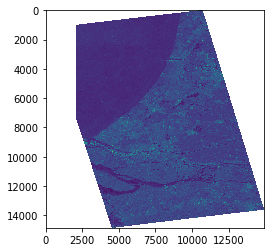

In [11]:
satellite_preprocessed = rio.open(path_to_output)
im=satellite_preprocessed.read()
plt.imshow(np.log(im[0]))

### Find water threshold through permanent water bodies

In [12]:
# download the waterbodies for the ROI 
water_body_url, wb_filename = get_water_body_file_url(satellite_preprocessed.bounds)
urllib.request.urlretrieve(water_body_url, '../data/water_bodies/' + wb_filename)

# crop them to ROI and upsample them to match the satellite image 
crop_image('../data/water_bodies/' + wb_filename, satellite_preprocessed.bounds)
water_bodies_cropped = rio.open('../data/water_bodies/{}_cropped.tif'.format(wb_filename[:-4]))
water_bodies_cropped_upsampled = water_bodies_cropped.read(out_shape=(satellite_preprocessed.height,
                                                                      satellite_preprocessed.width),
                                                           resampling=Resampling.nearest)
# calculate threshold
satellite_values = satellite_preprocessed.read(1)
water_threshold = get_water_threshold_from_water_bodies(water_bodies_cropped_upsampled, satellite_values)
print('water threshold: ', water_threshold)

water threshold:  -0.9948364484310117


### Show histogram

In [15]:
water_bodies_in = water_bodies_cropped_upsampled
satellite_in = satellite_values
permanent_water_value_in=12
water_body_values = water_bodies_in.squeeze()
water_values = satellite_in[water_body_values == permanent_water_value_in]
water_values_log = np.log10(water_values[water_values > 0])

(array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 3.4000000e+01, 8.2000000e+02, 2.2008000e+04,
        1.4650100e+05, 3.8192900e+05, 8.5925700e+05, 2.5736360e+06,
        8.3897750e+06, 1.1202407e+07, 4.3582320e+06, 6.9923000e+05,
        1.9101400e+05, 1.1426700e+05, 7.4979000e+04, 5.0723000e+04,
        3.7626000e+04, 2.9723000e+04, 2.5569000e+04, 2.2541000e+04,
        2.0419000e+04, 1.8966000e+04, 1.7513000e+04, 1.5878000e+04,
        1.3958000e+04, 1.2093000e+04, 1.0205000e+04, 8.6860000e+03,
        7.3690000e+03, 6.1160000e+03, 5.1620000e+03, 4.2990000e+03,
        3.7210000e+03, 3.0430000e+03, 2.6930000e+03, 2.2670000e+03,
        1.8500000e+03, 1.4930000e+03, 1.2740000e+03, 9.5000000e+02,
        7.7800000e+02, 6.4800000e+02, 5.1500000e+02, 4.1800000e+02,
        3.0700000e+02]),
 array([-3.        , -2.89795918, -2.79591837, -2.69387755, -2.59183673,
        -2.48979592, -2.3877551 , -2.28571429, -2.18367347, -2.08163265,
        -1.97

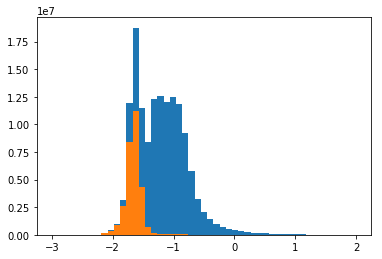

In [23]:
plt.hist(np.log10(satellite_values[satellite_values>0]), bins=np.linspace(-3,2,50))
plt.hist(np.log10(water_values[water_values > 0]), bins=np.linspace(-3,2,50))

### Retrieve slope information for ROI

In [13]:
# download the right altitude file for the ROI and extract it (it's a zip file)
altitude_file_url, al_filename = get_altitude_file_url(satellite_preprocessed.bounds)
urllib.request.urlretrieve(altitude_file_url, '../data/altitude/' + al_filename)
altitude_tif_file = extract_altitude_file(al_filename)

# crop it to ROI and upsample it to match the satellite image 
crop_image(altitude_tif_file, satellite_preprocessed.bounds)
altitudes_cropped = rio.open('../data/altitude/{}/{}_cropped.tif'.format(al_filename[:-4], al_filename[:-4]))
altitudes_cropped_upsampled = altitudes_cropped.read(out_shape=(satellite_preprocessed.height,
                                                                satellite_preprocessed.width),
                                                     resampling=Resampling.bilinear)

# get slope information
slopes = calculate_slopes(altitudes_cropped_upsampled[0], altitudes_cropped.bounds)

### Create mask

In [24]:
slope_threshold = 10     # degrees
permanent_water_values = 12
bin_mask = create_binary_mask(satellite_values, water_threshold, slopes, slope_threshold,
                              water_bodies_cropped_upsampled[0], permanent_water_values,
                              satellite_preprocessed.crs, satellite_preprocessed.transform, 'example')

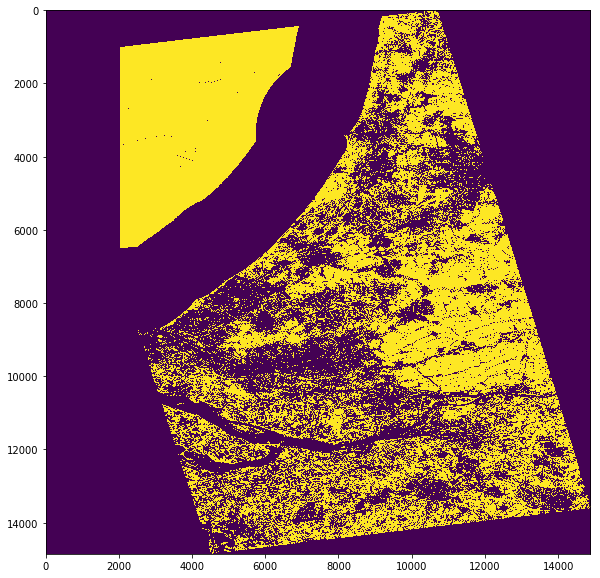

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(bin_mask)

## To do

- add mask for land
- check why NL is so flooded
- tidy up histogram code